In [5]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score

# -----------------------------
# Load Data
# -----------------------------
train_set = pd.read_csv("../0_DataPreparation/train_set.csv")
validation_set = pd.read_csv("../0_DataPreparation/validation_set.csv")

baseline_features = [
    'Warengruppe',
    'Temperatur',
    'Bewoelkung',
    'KielerWoche',
    'Feiertag',
    'Monat',
    'avg_sales_per_group_dayofyear'
]
target = 'Umsatz'

# -----------------------------
# Define Feature Types
# -----------------------------
categorical_features = ['Warengruppe', 'KielerWoche', 'Feiertag', 'Monat']
numerical_features = ['Temperatur', 'Bewoelkung', 'avg_sales_per_group_dayofyear']

# -----------------------------
# Preprocessing Pipelines
# -----------------------------

# Step to replace inf/-inf with NaN (before imputation)
inf_to_nan = FunctionTransformer(
    lambda X: np.where(np.isinf(X), np.nan, X),
    feature_names_out='one-to-one'
)

# Numeric pipeline
numeric_pipeline = Pipeline([
    ('inf_to_nan', inf_to_nan),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine into column transformer
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# -----------------------------
# Final Model Pipeline
# -----------------------------
model_pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('regressor', LinearRegression())
])

# -----------------------------
# Train Model
# -----------------------------
X_train = train_set[baseline_features]
y_train = train_set[target]
X_val = validation_set[baseline_features]
y_val = validation_set[target]

print("Training model...")
model_pipeline.fit(X_train, y_train)

# -----------------------------
# Helper to Get Feature Names
# -----------------------------
def get_feature_names(preprocessor):
    num_features = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numerical_features)
    cat_features = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
    return np.concatenate([num_features, cat_features])

# -----------------------------
# Print Linear Equation
# -----------------------------
feature_names = get_feature_names(preprocessor)
coefficients = model_pipeline.named_steps['regressor'].coef_
intercept = model_pipeline.named_steps['regressor'].intercept_

print("\nLinear Regression Equation:")
equation = "Umsatz = "
terms = [f"{coef:.4f}*{name}" for coef, name in zip(coefficients, feature_names)]
equation += " + ".join(terms)
equation += f" + {intercept:.4f}"
print(equation)

# -----------------------------
# Evaluation Function
# -----------------------------
def evaluate_model(model, X, y, set_name, show_adjusted=False):
    pred = model.predict(X)
    mse = mean_squared_error(y, pred)
    r2 = r2_score(y, pred)
    mape = np.mean(np.abs((y - pred) / np.where(y == 0, 1, y))) * 100

    print(f"\n{set_name} Set Performance:")
    print(f"- R²: {r2:.4f}")
    if show_adjusted:
        n = len(y)
        p = model.named_steps['preprocess'].transform(X).shape[1]
        adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
        print(f"- Adjusted R²: {adj_r2:.4f}")
    print(f"- MAPE: {mape:.2f}%")

evaluate_model(model_pipeline, X_train, y_train, "TRAINING", show_adjusted=True)
evaluate_model(model_pipeline, X_val, y_val, "VALIDATION")


Training model...

Linear Regression Equation:
Umsatz = 2.3984*Temperatur + -3.3592*Bewoelkung + 130.9917*avg_sales_per_group_dayofyear + 13.8861*Warengruppe_2 + 2.1919*Warengruppe_3 + 0.7325*Warengruppe_4 + 7.7533*Warengruppe_5 + 0.4556*Warengruppe_6 + 22.5416*KielerWoche_1.0 + -16.0792*Feiertag_Erster Mai + -39.0553*Feiertag_Erster Weihnachtstag (Vortag) + 44.5966*Feiertag_Karfreitag (Vortag) + -43.8156*Feiertag_Kein Feiertag + 36.0377*Feiertag_Neujahr (Vortag) + 5.5383*Feiertag_Ostermontag + 43.9292*Feiertag_Ostermontag (Vortag) + 38.0107*Feiertag_Pfingstmontag + -35.1451*Feiertag_Tag der Deutschen Einheit + 0.8799*Monat_2 + -7.4154*Monat_3 + -7.0453*Monat_4 + -11.3745*Monat_5 + -17.3297*Monat_6 + -12.6673*Monat_7 + -1.9133*Monat_8 + -7.8436*Monat_9 + -3.5462*Monat_10 + -0.9329*Monat_11 + -3.0738*Monat_12 + 252.7500

TRAINING Set Performance:
- R²: 0.8557
- Adjusted R²: 0.8551
- MAPE: 21.49%

VALIDATION Set Performance:
- R²: 0.8280
- MAPE: 23.38%


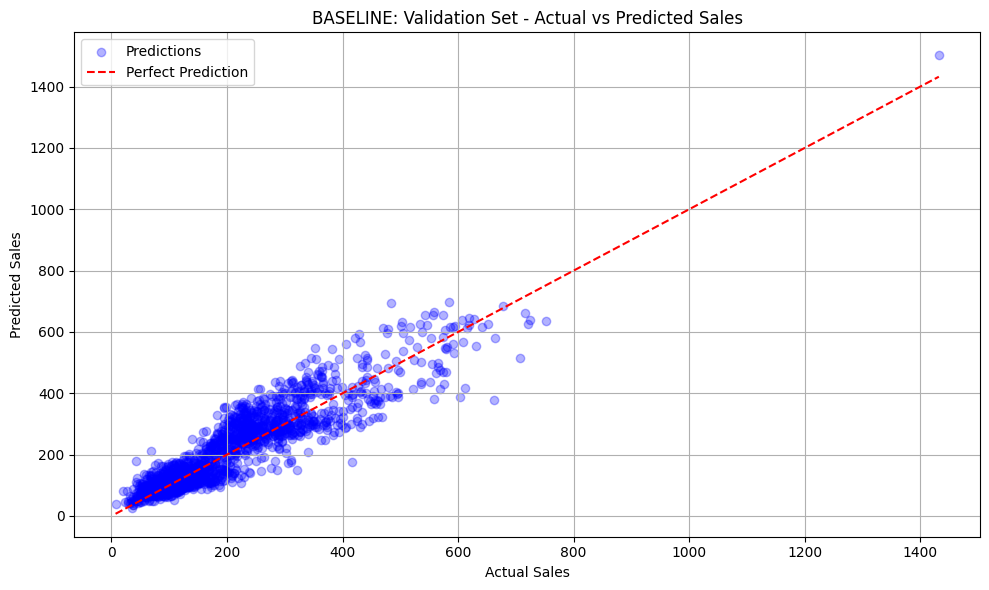

In [2]:
import matplotlib.pyplot as plt

# Predict on validation set
y_pred_val = model_pipeline.predict(X_val)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.3, color='blue', label='Predictions')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label='Perfect Prediction')
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("BASELINE: Validation Set - Actual vs Predicted Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


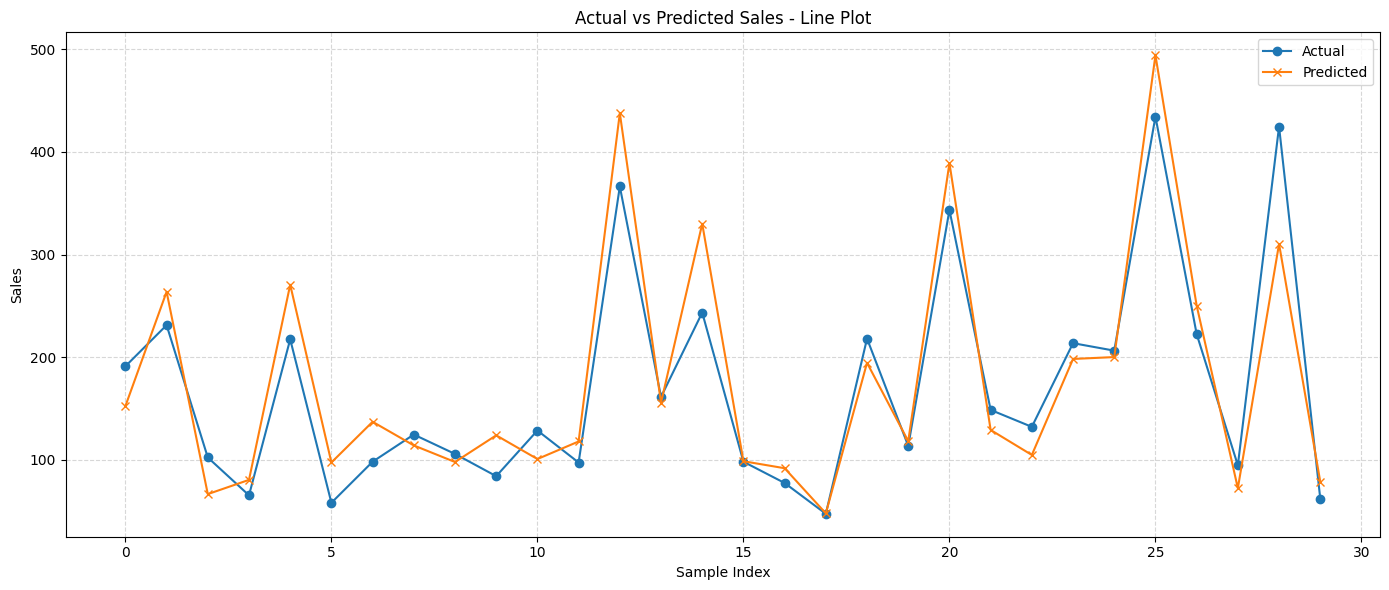

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Predict on validation set
y_pred_val = model_pipeline.predict(X_val)

# Select a sample to visualize
sample_size = 30
sample_indices = np.random.choice(len(y_val), sample_size, replace=False)

# Actual vs Predicted
actual = y_val.iloc[sample_indices].reset_index(drop=True)
predicted = pd.Series(y_pred_val[sample_indices])

# Plot
x = np.arange(sample_size)
width = 0.35

plt.figure(figsize=(14, 6))
plt.plot(actual, label='Actual', marker='o')
plt.plot(predicted, label='Predicted', marker='x')
plt.xlabel("Sample Index")
plt.ylabel("Sales")
plt.title("Actual vs Predicted Sales - Line Plot")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()